### development code for tbc et al

In [1]:
# Just your usual setup

import numpy as np
import scipy as sp
import scipy.signal as sps
import scipy.fftpack as fftpack 
import matplotlib.pyplot as plt
import sys
import getopt

%matplotlib inline

import matplotlib
matplotlib.rc('figure', figsize=(20, 12))

from datetime import  datetime

import fft8 as fft8 
import ld_utils as utils

import copy

# for image display
from PIL import Image
from IPython.display import HTML
import IPython.display 
from io import BytesIO
from base64 import b64encode

In [2]:
pi = np.pi
tau = np.pi * 2

# Make sure this is a power of two!
blocklenk = 2048
blocklen = (blocklenk * 1024)

In [3]:
def dosplot(B, A, freq = (315.0/88.0) * 8.0):
	w, h = sps.freqz(B, A)

	fig = plt.figure()
	plt.title('Digital filter frequency response')

	ax1 = fig.add_subplot(111)

	db = 20 * np.log10(abs(h))

	for i in range(1, len(w)):
		if (db[i] >= -10) and (db[i - 1] < -10):
			print(">-10db crossing at ", w[i] * (freq/pi) / 2.0) 
		if (db[i] >= -3) and (db[i - 1] < -3):
			print("-3db crossing at ", w[i] * (freq/pi) / 2.0) 
		if (db[i] < -3) and (db[i - 1] >= -3):
			print("<-3db crossing at ", w[i] * (freq/pi) / 2.0) 
		if (db[i] < -10) and (db[i - 1] >= -10):
			print("<-10db crossing at ", w[i] * (freq/pi) / 2.0) 
		if (db[i] < -20) and (db[i - 1] >= -20):
			print("<-20db crossing at ", w[i] * (freq/pi) / 2.0) 

	plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h)), 'b')
	plt.ylabel('Amplitude [dB]', color='b')
	plt.xlabel('Frequency [rad/sample]')

	plt.show()

def doplot(B, A, freq = (315.0/88.0) * 8.0):
	w, h = sps.freqz(B, A)

	fig = plt.figure()
	plt.title('Digital filter frequency response')
	
	db = 20 * np.log10(abs(h))
	for i in range(1, len(w)):
		if (db[i] >= -10) and (db[i - 1] < -10):
			print(">-10db crossing at ", w[i] * (freq/pi) / 2.0) 
		if (db[i] >= -3) and (db[i - 1] < -3):
			print(">-3db crossing at ", w[i] * (freq/pi) / 2.0) 
		if (db[i] < -3) and (db[i - 1] >= -3):
			print("<-3db crossing at ", w[i] * (freq/pi) / 2.0) 

	ax1 = fig.add_subplot(111)
	
	plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h)), 'b')
	plt.ylabel('Amplitude [dB]', color='b')
	plt.xlabel('Frequency [rad/sample]')

	ax2 = ax1.twinx()
	angles = np.unwrap(np.angle(h))
	plt.plot(w * (freq/pi) / 2.0, angles, 'g')
	plt.ylabel('Angle (radians)', color='g')
	
	plt.grid()
	plt.axis('tight')
	plt.show()

def doplot2(B, A, B2, A2, freq = (315.0/88.0) * 8.0):
	w, h = sps.freqz(B, A)
	w2, h2 = sps.freqz(B2, A2)

#	h.real /= C
#	h2.real /= C2

	begin = 0
	end = len(w)
#	end = int(len(w) * (12 / freq))

#	chop = len(w) / 20
	chop = 0
	w = w[begin:end]
	w2 = w2[begin:end]
	h = h[begin:end]
	h2 = h2[begin:end]

	v = np.empty(len(w))
	
#	print len(w)

	hm = np.absolute(h)
	hm2 = np.absolute(h2)

	v0 = hm[0] / hm2[0]
	for i in range(0, len(w)):
#		print i, freq / 2 * (w[i] / pi), hm[i], hm2[i], hm[i] / hm2[i], (hm[i] / hm2[i]) / v0
		v[i] = (hm[i] / hm2[i]) / v0

	fig = plt.figure()
	plt.title('Digital filter frequency response')

	ax1 = fig.add_subplot(111)

	v  = 20 * np.log10(v )

#	plt.plot(w * (freq/pi) / 2.0, v)
#	plt.show()
#	exit()

	plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h)), 'r')
	plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h2)), 'b')
	plt.ylabel('Amplitude [dB]', color='b')
	plt.xlabel('Frequency [rad/sample]')
	
	ax2 = ax1.twinx()
	angles = np.unwrap(np.angle(h))
	angles2 = np.unwrap(np.angle(h2))
	plt.plot(w * (freq/pi) / 2.0, angles, 'g')
	plt.plot(w * (freq/pi) / 2.0, angles2, 'y')
	plt.ylabel('Angle (radians)', color='g')

	plt.grid()
	plt.axis('tight')
	plt.show()

# This matches FDLS-based conversion surprisingly well (i.e. FDLS is more accurate than I thought ;) )
def BA_to_FFT(B, A, blocklen):
    return np.complex64(sps.freqz(B, A, blocklen, whole=True)[1])



# Draws a uint16 image as a uint8, defaults to one frame
def drawdata(bm, x = 2800, y = 525, hscale = 1, vscale = 2, outsize = None):
#    bmf = np.float32(bm) / 65536.0
    if y is None:
        y = len(bm) // x
        
    if outsize is None:
        outsize = (x * hscale, y * vscale)
    
    bmf = np.uint8(bm[0:x*y] / 256.0)
    print(bmf.shape)
    if x is not None:
        bms = (bmf.reshape(len(bmf)//x, -1))
    else:
        bms = bmf
    
    print(bms.dtype, bms.shape, bms[:][0:y].shape)
    im = Image.fromarray(bms[0:y])
    im = im.resize(outsize)
#    imshow(np.asarray(im))
    b = BytesIO()
    im.save(b, format='png')
    return IPython.display.Image(b.getvalue())
                         
#drawdata(data)                         


In [4]:
# System default specs for NTSC and PAL.

NTSC_hz_ire = (9300000 - 7600000) / 140.0 # Later disks may have a higher white point

SysParams_NTSC = {
    'system_name': 'NTSC',
    
    'audio_lfreq': 2301136,
    'audio_rfreq': 2812499,

    'analog_audio': True,
    'audio_filtwidth': 200000,
    'audio_filtorder': 1,

    'fsc_mhz': (315.0 / 88.0),
    'line_period': 63.5, # in usecs

    # video frequencies 
    # per spec, range from -40 to 100 IRE is 1.7mhz, so 12142 ire/mhz
    'hz_ire': NTSC_hz_ire,
    
    'videorf_sync'  : 8100000-(NTSC_hz_ire * -40),
    'videorf_0ire'  : 8100000,
    'videorf_7.5ire': 8100000+(NTSC_hz_ire*7.5),
    'videorf_100ire': 8100000+(NTSC_hz_ire*100), # NOTE: slightly higher on later disks

    # IRE range is actually -40 to 110, but leave some margin here and match 0-65534 scaling
    'ire_min': -60,
    'ire_max': 140,

    # changeable defaults
    #'deemp': (120, 320), # actual deemp timing
    'deemp': (135, 320),

    'vbpf': (3200000, 14000000),
    'vbpf_order': 1,
    
    'vlpf_freq': 4200000,   # in mhz
    'vlpf_order': 4 # butterworth filter order
}

SysParams_PAL = {
    # System parameters
    'system_name': 'PAL',

    'fsc_mhz': 4.43361875,
    'line_period': 64, # in usecs
    
    'audio_lfreq': 683593,
    'audio_rfreq': 1066400,

    # video frequencies 
    'videorf_sync': 6760000, # on LD this includes a very strong pilot signal
    'videorf_0ire': 7100000,
    'videorf_100ire': 7900000,

    'ire_min': -95, # needed for pilot signal
    'ire_max': 145,

    # changeable defaults
    'analog_audio': False, # not true for later PAL

    'deemp': (100, 400),

    # XXX: guessing here!
    'vbpf': (2600000, 11000000),
    'vbpf_order': 3,
    'vlpf_freq': 4800000,	# in mhz
    'vlpf_order': 5,		# butterworth filter order

    'audio_filtwidth': 200000,
    'audio_filtorder': 1,
}

# support reloading/rerunning from ipython
try:
    # a dummy load
    tmp = SysParams['fsc_mhz']
except:
    SysParams = copy.deepcopy(SysParams_NTSC)
    

In [5]:
# Domesday Duplicator system uses 32mhz/10bit, expressed as 16-bit signed integers
CapParams_DomesdayDuplicator = {
    'freq': 40.0,
    'dtype': np.int16,
}

# cxadc can only really capture at 8fsc (28.8xmhz), with 8-bit unsigned samples
CapParams_cxadc = {
    'freq': (315.0 / 88.0) * 8.00,
    'dtype': np.uint8,
}

try:
    tmp = CapParams['freq']
except:
    CapParams = CapParams_cxadc

In [6]:
# old lddecode format
minire = -60
maxire = 140
hz_ire_scale = (9300000 - 8100000) / 100
minn = 8100000 + (hz_ire_scale * -60)
out_scale = 65534.0 / (maxire - minire)

In [7]:
CapParams = CapParams_cxadc
CapParams = CapParams_DomesdayDuplicator
SysParams = copy.deepcopy(SysParams_NTSC)

In [8]:
SysParams['vsync_freq'] = 1000000
SysParams['vsync_order'] = 3

In [9]:
OverrideParams = {}

params = {}

for p in [SysParams, CapParams, OverrideParams]:
    for k in p.keys():
        print(k, p[k])
        params[k] = p[k]

system_name NTSC
audio_lfreq 2301136
audio_rfreq 2812499
analog_audio True
audio_filtwidth 200000
audio_filtorder 1
fsc_mhz 3.5795454545454546
line_period 63.5
hz_ire 12142.857142857143
videorf_sync 8585714.285714285
videorf_0ire 8100000
videorf_7.5ire 8191071.428571428
videorf_100ire 9314285.714285715
ire_min -60
ire_max 140
deemp (135, 320)
vbpf (3200000, 14000000)
vbpf_order 1
vlpf_freq 4200000
vlpf_order 4
vsync_freq 1000000
vsync_order 3
freq 40.0
dtype <class 'numpy.int16'>


In [10]:
def inrange(a, mi, ma):
    return (a >= mi) & (a <= ma)

In [11]:
# from http://tlfabian.blogspot.com/2013/01/implementing-hilbert-90-degree-shift.html
hilbert_filter = np.fft.fftshift(
    np.fft.ifft([0]+[1]*200+[0]*200)
    #np.fft.ifft([0]+[1]*(blocklen//4)+[0]*(blocklen//4))
)

# Now construct the FFT transform of the hilbert filter.  
# This can be complex multiplied with the raw RF to do the 'heavy lifting'
fft_hilbert = np.fft.fft(hilbert_filter, blocklen)

def filtfft(filt, blen = blocklen):
    return sps.freqz(filt[0], filt[1], blen, whole=1)[1]

# A rather pants attempt at doing an MTF function. This needs to be better.
[tf_b, tf_a] = sps.zpk2tf(.1, -.5, 1.0)
Fmtf = filtfft([tf_b, tf_a])

# This prepares the needed transforms to do the actual video decoding
def prepare_video_filters(SP):
    SP['freq_hz'] = SP['freq'] * 1000000
    SP['line_px'] = SP['freq_hz'] * (SP['line_period'] / 1000000)
        
    freq_hz = SP['freq_hz']
    freq_hz_half = SP['freq_hz'] / 2

    # RF BPF and analog audio cut filters
    SP['FRFVideo'] = filtfft(sps.butter(SP['vbpf_order'], [SP['vbpf'][0]/freq_hz_half, SP['vbpf'][1]/freq_hz_half], btype='bandpass'))
    
    if SP['analog_audio'] and SP['audio_filtorder']: 
        SP['Fcutl'] = filtfft(sps.butter(SP['audio_filtorder'], [(SP['audio_lfreq'] - SP['audio_filtwidth'])/freq_hz_half, (SP['audio_lfreq'] + SP['audio_filtwidth'])/(freq_hz_half)], btype='bandstop'))
        SP['Fcutr'] = filtfft(sps.butter(SP['audio_filtorder'], [(SP['audio_rfreq'] - SP['audio_filtwidth'])/freq_hz_half, (SP['audio_rfreq'] + SP['audio_filtwidth'])/(freq_hz_half)], btype='bandstop'))
        
        SP['FRFVideo'] *= (SP['Fcutl'] * SP['Fcutr'])
    
    # standard post-demod LPF
    SP['Fvideo_lpf'] = filtfft(sps.butter(SP['vlpf_order'], SP['vlpf_freq']/freq_hz_half, 'low'))
    SP['Fvideo_lpf05'] = filtfft(sps.butter(SP['vlpf_order'], 0.5/freq_hz_half, 'low'))

    # post-demod deemphasis filter
    [tf_b, tf_a] = sps.zpk2tf(-SP['deemp'][1]*(10**-10)/2.0, -SP['deemp'][0]*(10**-10)/2.0, SP['deemp'][0] / SP['deemp'][1])
    SP['Fdeemp'] = filtfft(sps.bilinear(tf_b, tf_a, 1.0/freq_hz_half))

    # Post processing:  lowpass filter + deemp
    SP['FVideo'] = SP['Fvideo_lpf'] * SP['Fdeemp']
    SP['FVideo05'] = SP['Fvideo_lpf05'] * SP['Fdeemp']

In [12]:
# The actual video demodulation code
def dodemod(params, data, clip = None, usemtf = False, cutarf = False):
    prepare_video_filters(params)

    data_fft = np.fft.fft(data)
    
    datac = data_fft * params['FRFVideo']
    if usemtf is True:
        datac *= Fmtf
    
    hilbert = np.fft.ifft(datac * fft_hilbert)

    tangles = np.angle(hilbert)
    dangles = np.pad(np.diff(tangles), (1, 0), mode='constant')

    # make sure unwapping goes the right way
    if (dangles[0] < -pi):
            dangles[0] += tau

    tdangles2 = np.unwrap(dangles) 
    demod = (tdangles2 * (params['freq_hz'] / tau))

    demod_fft = np.fft.fft(demod)

    # note: imaginary component of this ifft is virtually zero
    output = np.fft.ifft(demod_fft * params['FVideo']).real
    
    return output


In [13]:
def lineplot(output, param):
    plt.plot(output)
    
    if param['system_name'] == 'PAL':
        plt.axhline(7100000, color='black') # black
        plt.axhline(7900000, color='black') # white

        # burst
        plt.axhline(7100000 - (800000 * 1.5 / 7), color='g')
        plt.axhline(7100000 + (800000 * 1.5 / 7), color='g')

        # pilot low (pilot high is 7.1mhz)
        plt.axhline((7900000-(800000/.7))-(800000*(3/7)), color='b')
    else: # NTSC
        
        plt.axhline(params['videorf_0ire'], color='black') # 0IRE
        plt.axhline(params['videorf_7.5ire'], color='black') # black for most disks
        plt.axhline(params['videorf_100ire'], color='black') # white

        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * 80), color='blue')
        
        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * 20), color='green')
        plt.axhline(params['videorf_0ire'] - (params['hz_ire'] * 20), color='green')
        
        # sync
        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * -40), color='blue')

In [14]:
prepare_video_filters(params)

In [15]:
def calcsnr(a):
    stdire = np.std(a) / NTSC_hz_ire
    print(20 * np.log10(100 / stdire))

In [16]:
#infile = open('.raw', 'rb')
infile = infile = open('ggv1069_22000.raw', 'rb')
#infile.seek(1024 * 1024 * 1024)
inbuf = infile.read(1024 * 1024 * 8)
indata1 = np.fromstring(inbuf, 'int16', len(inbuf) // 2)

data1 = indata1[400000:400000+blocklen]
#data2 = indata1[blocklen:blocklen*2]


In [17]:
blockcut = 1024

SysParams = copy.deepcopy(SysParams_NTSC)
params = {}

In [18]:
for p in [SysParams, CapParams, OverrideParams]:
    for k in p.keys():
        #print(k, p[k])
        params[k] = p[k]

        adj = 1
params['deemp'] = [120*adj, 320*adj]
params['vbpf'] = (3500000, 14000000)
params['vbpf_order'] = 6

params['ahpf_freq'] = 3100000
params['ahpf_order'] = 2

params['vlpf_freq'] = 4200000
params['vlpf_order'] = 5

output1 = dodemod(copy.deepcopy(params), data1, usemtf=False)
#calcsnr(output1[214400:215500]), calcsnr(output1[217000:218000]), calcsnr(output1[213820:213950])
calcsnr(output1[156000:157000]), calcsnr(output1[169100:169500])

11.676235487
12.2862564482


(None, None)

In [19]:
def sqsum(cmplx):
    return np.sqrt((cmplx.real ** 2) + (cmplx.imag ** 2))

13.0101412113
11.1580827536


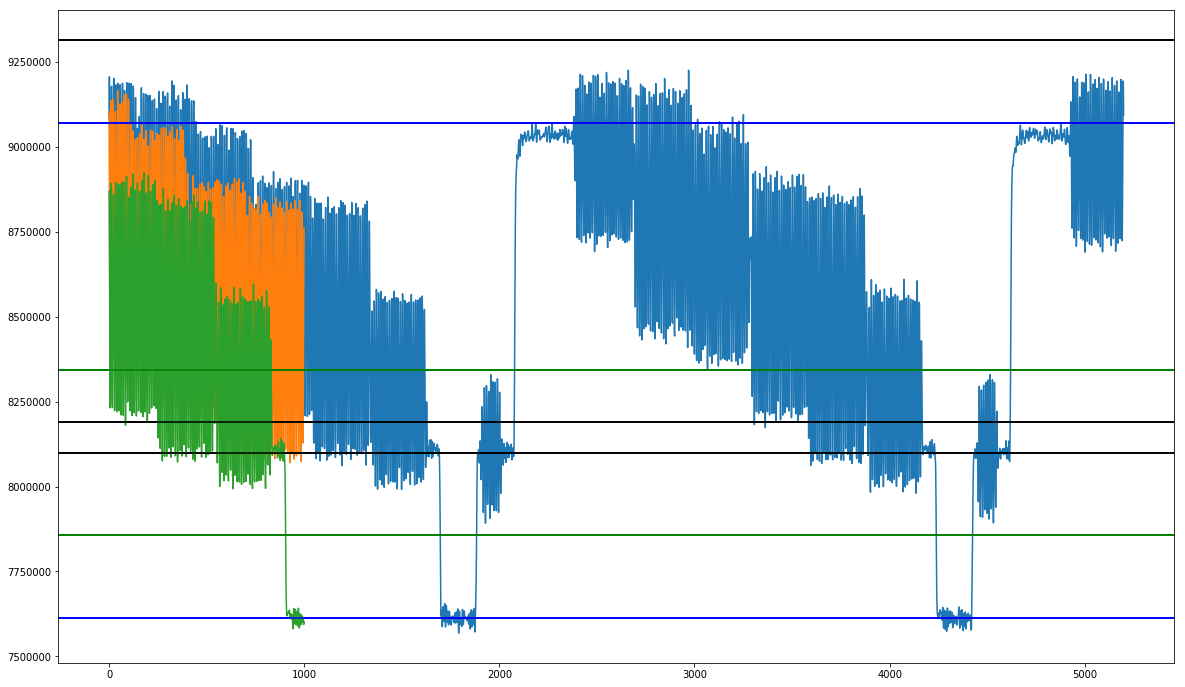

In [20]:
for p in [SysParams, CapParams, OverrideParams]:
    for k in p.keys():
        #print(k, p[k])
        params[k] = p[k]

adj = .6
params['deemp'] = [120*adj, 320*adj]
params['vbpf'] = (3500000, 13200000)
params['vbpf_order'] = 3

params['audio_filtwidth'] = 150000
params['audio_filtorder'] = 1

params['vlpf_freq'] = 4200000
params['vlpf_order'] = 2

output1 = dodemod(copy.deepcopy(params), data1, usemtf=False)

lineplot(output1[219500:224700], params)
lineplot(output1[199500:200500], params)
lineplot(output1[202500:203500], params)
calcsnr(output1[199500:200500])
calcsnr(output1[202500:203500])

In [176]:
# The actual (new?) video demodulation code

#def dodemod(params, data, clip = None, usemtf = False, cutarf = False):
paramsc = copy.deepcopy(params)

ptr = 1024 * 1600
data1 = indata1[ptr:ptr + blocklen]

adj = .7
paramsc['deemp'] = [120*adj, 320*adj]
paramsc['vbpf'] = (3500000, 13200000)
paramsc['vbpf_order'] = 3

paramsc['audio_filtwidth'] = 150000
paramsc['audio_filtorder'] = 1

paramsc['vlpf_freq'] = 4200000
paramsc['vlpf_order'] = 5

prepare_video_filters(paramsc)

indata_fft = np.fft.fft(data1)
indata_fft_filt = indata_fft * paramsc['FRFVideo']

indata_fft_filt *= Fmtf

hilbert = np.fft.ifft(indata_fft_filt * fft_hilbert)

tangles = np.angle(hilbert)
dangles = np.pad(np.diff(tangles), (1, 0), mode='constant')

# make sure unwapping goes the right way
if (dangles[0] < -pi):
    dangles[0] += tau
    
tdangles2 = np.unwrap(dangles) 
tdangles2[tdangles2 < 0] += tau
tdangles2[tdangles2 > tau] -= tau
demod = (tdangles2 * (paramsc['freq_hz'] / tau))

demod_fft = np.fft.fft(demod)
output = np.fft.ifft(demod_fft * paramsc['FVideo']).real

calcsnr(output[399630:401430])

10.1074051801


In [177]:
# emperical work determined that a single-pole low frequency filter effectively 
# detects the end of a (regular) sync pulse.  peak levels determine which type 
# of sync pulse. A regular pulse should peak around .8, a half pulse around .5-.6, 
# and a vsync pulse ~1 (with fake peaks, bottom ~.2)

f = sps.butter(1, 0.05/(params['freq'] / 2.0), btype='low')
synclpfb = filtfft(f)

In [178]:
output

array([ 7599129.34486916,  7571155.18104165,  7470220.95076705, ...,
        7602547.85123421,  7600324.12141176,  7600541.62873182])

In [179]:
# filtering for vsync pulses from -55 to -25ire seems to work well even on rotted disks

output_sync = (output > (params['videorf_0ire'] + (params['hz_ire'] * -55))) & (output < (params['videorf_0ire'] + (params['hz_ire'] * -25)))

In [180]:
output_syncf = np.fft.ifft(np.fft.fft(output_sync) * synclpfb).real

In [181]:
syncs2 = np.diff(output_syncf > .2)
syncs3 = np.diff(output_syncf > .3)

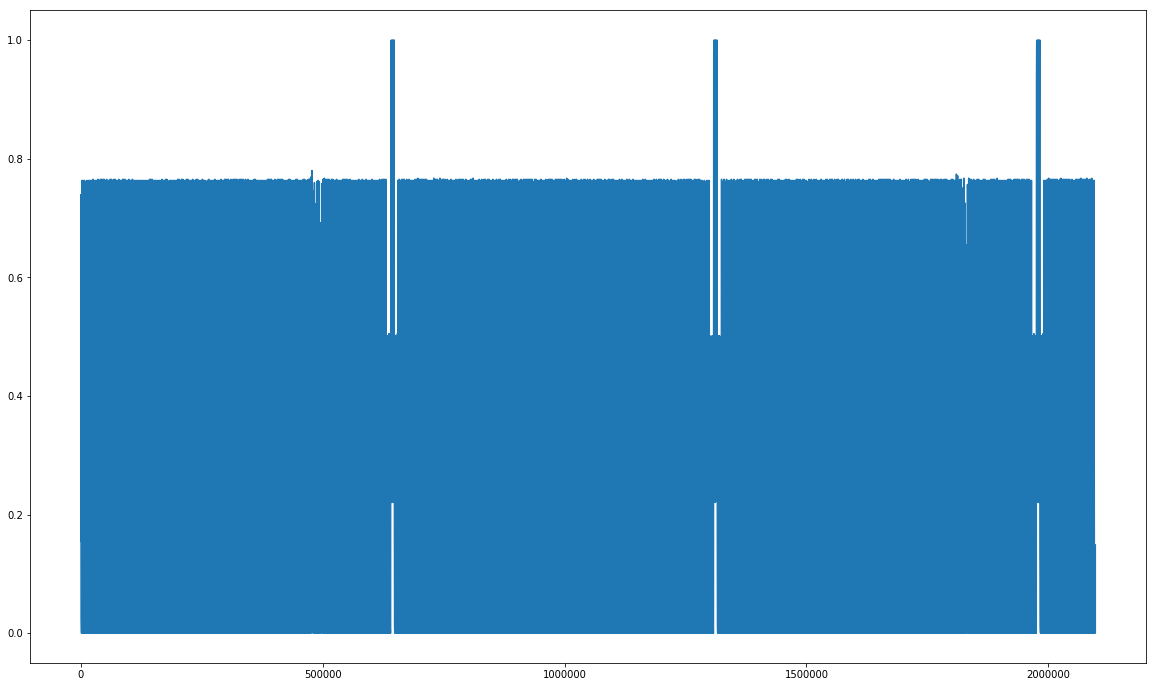

In [182]:
plt.plot(output_syncf)

In [183]:
prepare_video_filters(params)

In [184]:
# state 1: find vsync and first full hsync.  determine which line it is as well...

loc = 0
imglen = (int)((params['freq_hz'] / 59.976) * 1.25)

if (loc + imglen) > len(output_syncf):
    print("get more data")

# find the next sync point.  should be > .9
syncloc = np.argmax(output_syncf[loc:loc+imglen])

if np.max(output_syncf[loc:loc+imglen]) < .9:
    print("oops.  can't find a good sync")



In [185]:
syncloc

647817

In [186]:
# does this actually need to look backwards?  *maybe* on the first use...
def findburstfromsync(syncf, center, forward):
    # we don't know where *in* the vsync the filtered peak is, but we can look -/+ 3 lines from any point of it 
    # to find the previous and next syncs

    ilinepx = int(params['line_px'])
    
    burstloc = center
    if forward:
        burstloc += (ilinepx * 3)
    else:
        burstloc -= (ilinepx * 3)
        
    lastpeak = burstloc
    
    while True:
        if forward:
            searchend = int(burstloc + (ilinepx / 1.5))
            if searchend > len(output_syncf):
                return None
            tmp = output_syncf[burstloc:searchend]
        else:
            searchend = int(burstloc - (ilinepx / 1.5))
            if searchend < 0:
                return None
            tmp = output_syncf[searchend:burstloc]
            
        peaklevel = np.max(tmp)
        
        travel = (ilinepx // 10)
        
        if peaklevel < .3: # peak is too small to be anything, move 1/2 line
            travel = (ilinepx // 2)
            peakloc = lastpeak
        elif forward: # accept peak
            peakloc = burstloc + np.argmax(tmp)
        else:
            peakloc = searchend + np.argmax(tmp)
        
        print(burstloc, peakloc, peaklevel)

        if peaklevel > .7:
            return peakloc, np.abs(peakloc - lastpeak) > (params['line_px'] * .65)

        lastpeak = peakloc
        
        if forward:
            burstloc = peakloc + travel
        else:
            burstloc = peakloc - travel
            
#        break
        
nextline, ishalf = findburstfromsync(output_syncf, syncloc, True)
#findburstfromsync(output_syncf, syncloc, False) 
    

655437 655824 0.763370545638


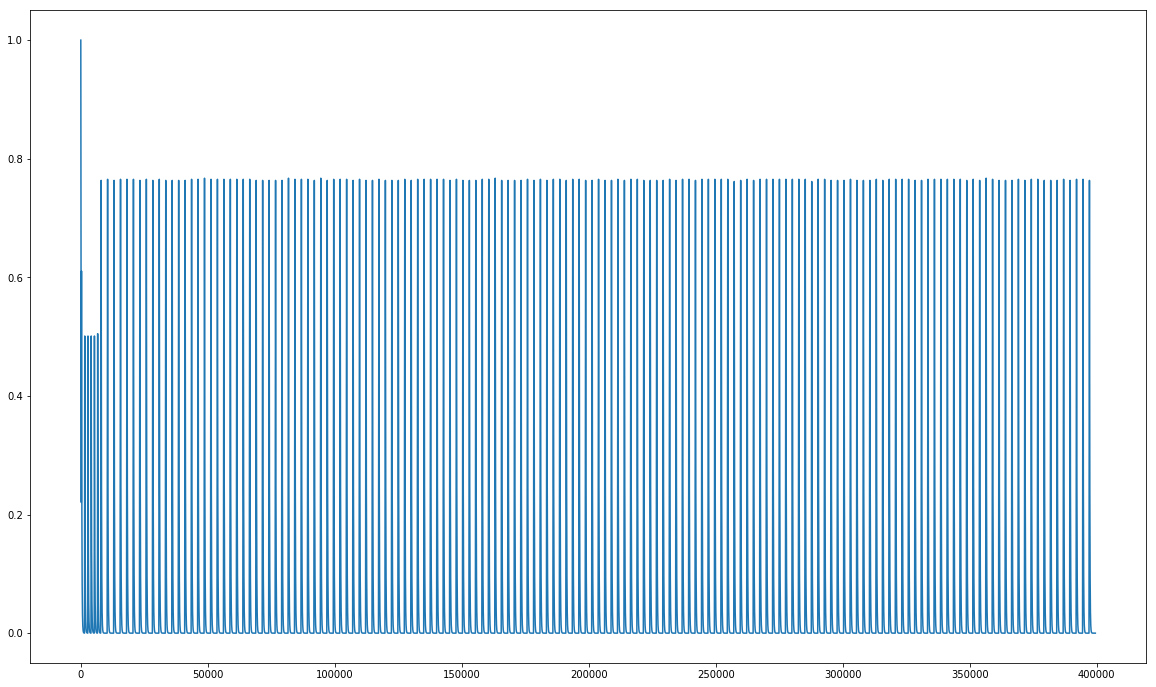

In [188]:
plt.plot(output_syncf[syncloc:syncloc+399430])

In [189]:
nextline, ishalf

(655824, False)

In [190]:
reduced = (output - minn) / hz_ire_scale
output_u16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)

In [191]:
# state 2: find the (rough) locations of each following line

ilinepx = int(params['line_px'])
lines = np.zeros((255 * ilinepx), dtype=np.uint16)

curloc = nextline

lineinfo = [curloc]
for i in range(0, 253):
    prevloc = curloc
    
    curloc += int(params['line_px'] * .9)
    offset = np.argmax(output_syncf[curloc:curloc + int(params['line_px'] * .2)])
    curloc += offset # + 8 # TODO: fix adjustment factor?
    
    #aftersync = np.where(output[curloc:curloc + 12] > 8080000)[0]
    #if len(aftersync):
    #    curloc += aftersync[0]
    
    # if the burst doesn't look good, reuse the last one
    if (output_syncf[curloc] < .7) and not inrange((curloc - prevloc), params['line_px'] * .99, params['line_px'] * 1.01):
        print(curloc)
        curloc = prevloc + (lineinfo[-1] - lineinfo[-2])
        print(curloc)
        
    #print(curloc, output[curloc], output[curloc+8])

    lineinfo.append(curloc)
    
    lines[i * ilinepx:(i * ilinepx)+(curloc - prevloc)] = output_u16[prevloc:curloc]

In [192]:
target = 8100000-hz_ire_scale*20

In [193]:
# crude zero-crossing calculator.

def calczc(data, start_offset, target, count=10):
    if data[start_offset] < target:
        locs = np.where(data[start_offset:start_offset+count] >= target)[0]
        offset = 0
    else:
        locs = np.where(data[start_offset:start_offset+count] <= target)[0]
        offset = -1
    
    if len(locs) == 0:
        return None
        
    x = start_offset + locs[0]
    
    a = data[x - 1] - target
    b = data[x] - target
    
    y = -a / (-a + b)

    #print(x, y, locs, data[start_offset:start_offset+locs[0] + 1])

    return x-1+y


In [194]:
lineinfo2 = []

for l in lineinfo:
    zc = calczc(output, l - 5, target, 20)
    
    if zc is None:
        lineinfo2.append(l)
        continue
        
    lineinfo2.append(zc)
    #print(l, output[l], output[l + 1], output[l + 2])
    


In [195]:
# now to get fine sync!

In [196]:
from scipy import interpolate

# This uses numpy's interpolator, which works well enough
def scale(buf, begin, end, tgtlen):
#        print("scaling ", begin, end, tgtlen)
        ibegin = int(begin)
        iend = int(end)
        linelen = end - begin

        dist = iend - ibegin + 1
        arr = np.linspace(0, dist, num=dist)
#       print(arr, dist, begin, ibegin, ibegin + dist)
        spl = interpolate.splrep(arr, buf[ibegin:ibegin + dist])
        arrout = np.linspace(begin - ibegin, linelen, tgtlen)

        return interpolate.splev(arrout, spl)
    

In [197]:
def downscale(data, lineinfo):
    dsout = np.zeros((len(lineinfo) * ilinepx), dtype=np.double)    

    sfactor = []

    for l in range(0, len(lineinfo) - 1):
        scaled = scale(data, lineinfo[l] + 0, lineinfo[l + 1], 910)
        sfactor.append((lineinfo[l + 1] - lineinfo[l]) / 910)

        dsout[l * 910:(l + 1)*910] = scaled
        
    return dsout, sfactor

lines, sfactor = downscale(output, lineinfo2)
    
reduced = (lines - minn) / hz_ire_scale
lines16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)


(230230,)
uint8 (253, 910) (253, 910)


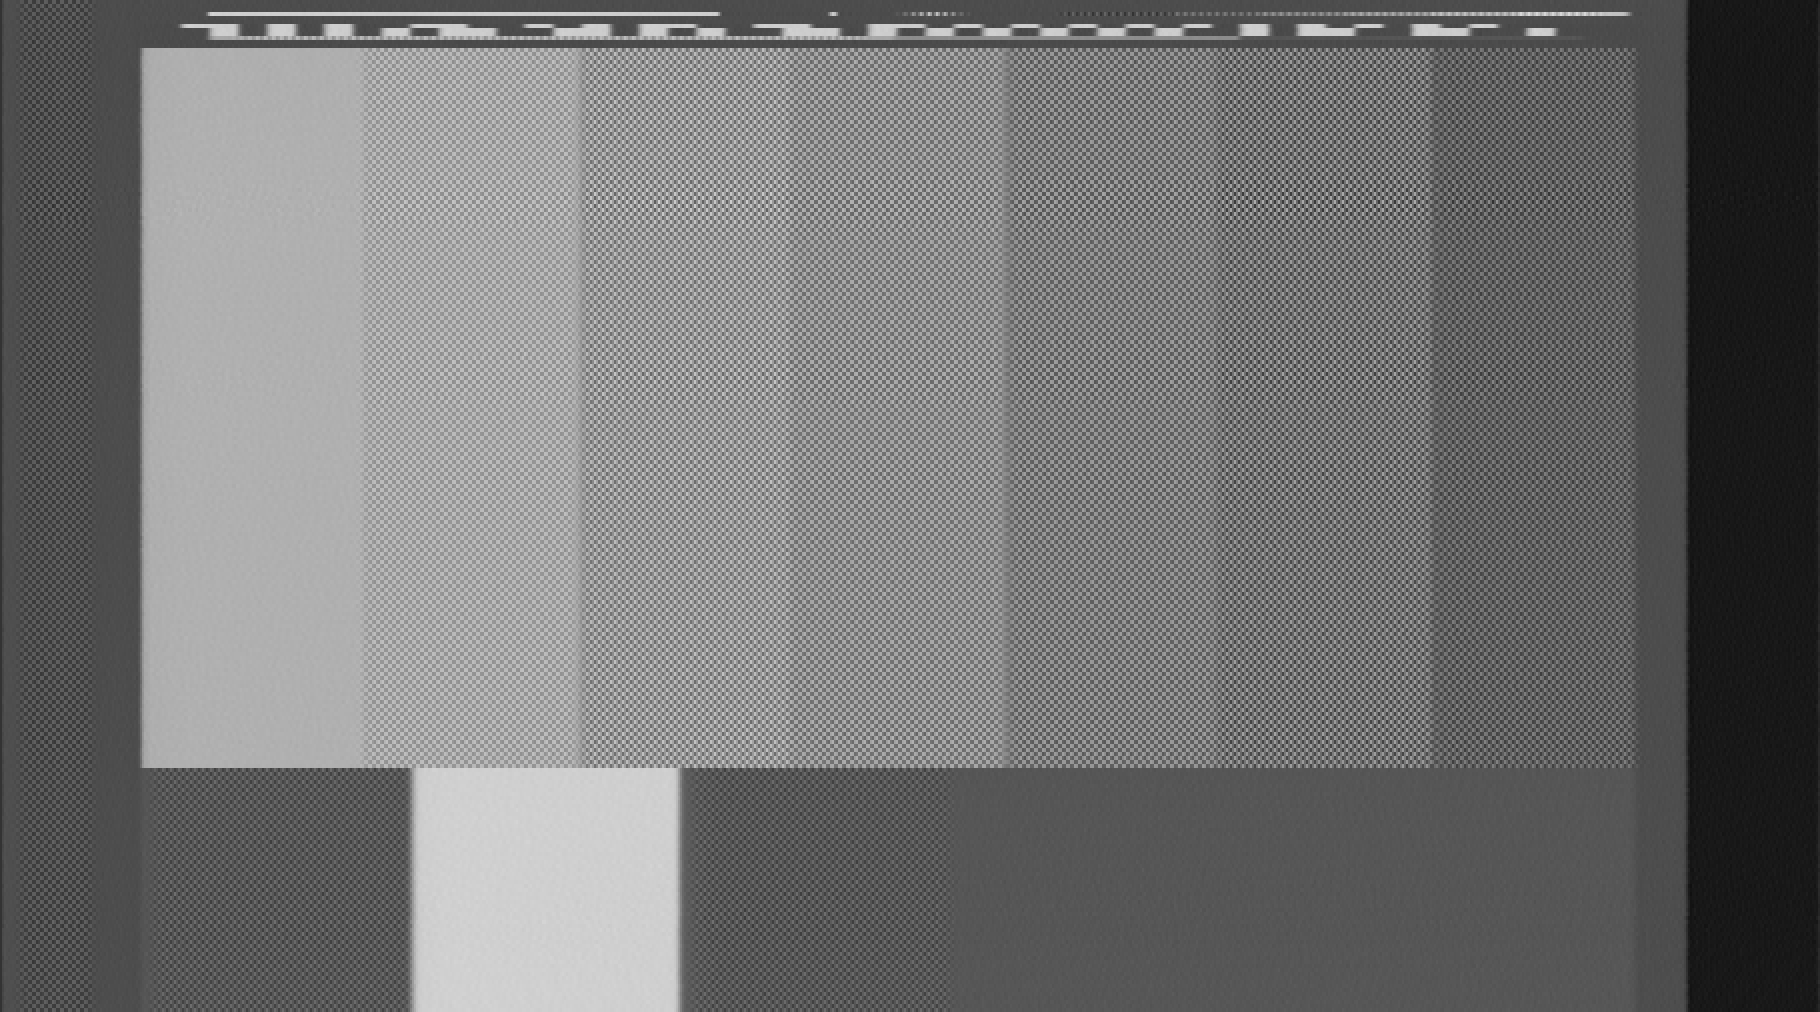

In [198]:
drawdata(lines16, 910, len(lineinfo2)-1, hscale=2, vscale=4)

In [199]:
def phasecorrect(sdata, lineinfo, mult = 0.25):
    loutput = []
    errors = []

    for l in range(0, len(lineinfo) - 1):
        subset = sdata[l * 910: (l + 1) * 910][5:60]

        np.where(np.abs(subset - 8100000) > 120000)[0]

        peaks = np.where(np.abs(subset - 8100000) > 150000)[0]
        toffset = 0

        for loc in peaks:
            zp = calczc(subset, loc, 8100000)

            offset = (zp - loc - 1)
            toffset += offset

    #        print(zp, offset)

        errors.append(toffset)
        #print(l, toffset / len(peaks) * sfactor[l])

        loutput.append(lineinfo[l] - ((toffset * mult) / len(peaks) * sfactor[l]))

    loutput.append(lineinfo[-1])
    
    return loutput, errors
    

In [201]:
lineinfo_cur = lineinfo2.copy()
#lines, sfactor = downscale(output, lineinfo_cur)

errs = np.zeros((6, len(lineinfo_cur) - 1), dtype=np.double)

for i in range(0, 6):
    lines, sfactor = downscale(output, lineinfo_cur)
    lineinfo_prev = lineinfo_cur
    lineinfo_cur, err = phasecorrect(lines, lineinfo_prev, 0.5 / (i + 1))
      
    errs[i] = err
    print(np.std(err), np.mean(np.abs(err)), np.max(np.abs(err)))

3.62949018483 3.58829378199 6.70640863994
3.28250749912 2.97014236402 6.75216326419
1.41923577593 1.08369034647 5.1696819948
0.822994442491 0.59886558942 3.54138707209
0.633909486088 0.450868265481 2.81378923496
0.496375509826 0.358773071822 2.68868055043


(230230,)
uint8 (253, 910) (253, 910)


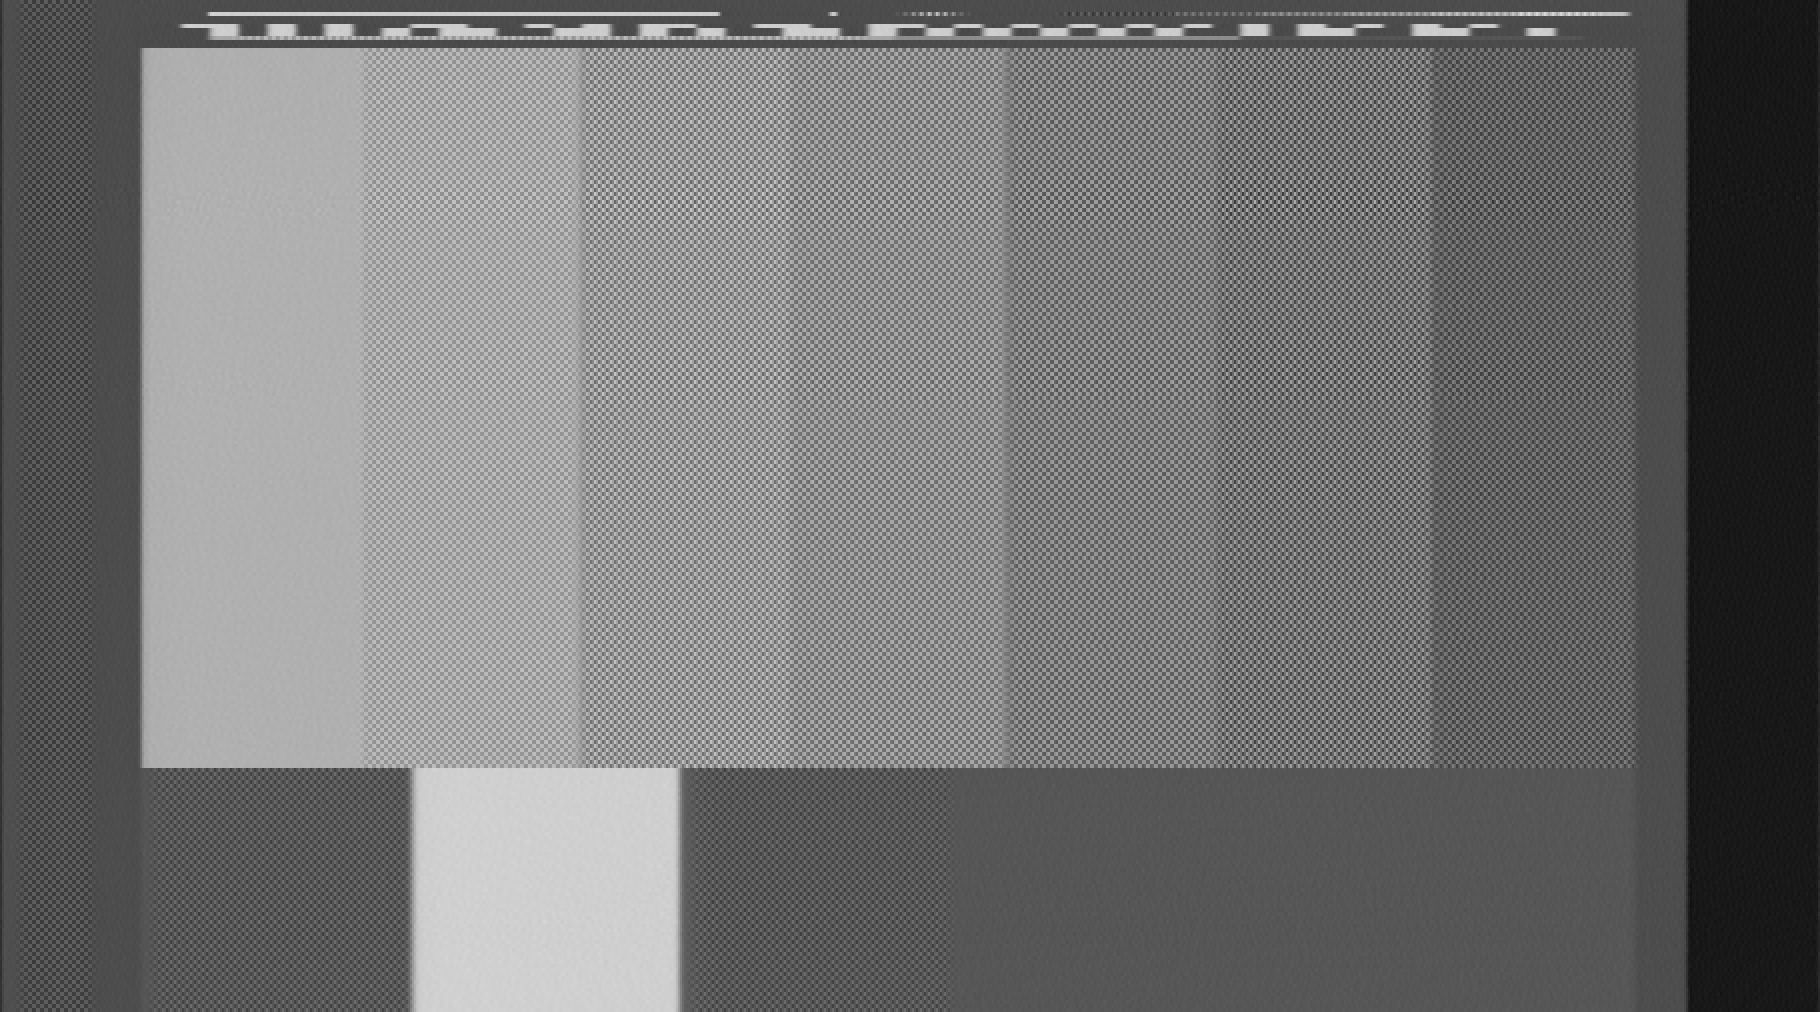

In [202]:
reduced = (lines - minn) / hz_ire_scale
lines16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)

drawdata(lines16, 910, len(lineinfo2)-1, hscale=2, vscale=4)